Work book Notes:

In this notebook we will first use stacking models on preprocessed data with no polynomial form. Then will build stacking models on polynomial data forms.



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def replace_age_fraction(df_train):
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [5]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [6]:
replace_age_fraction(df_train)

0


In [7]:
replace_na_to_mode(df_train)

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [47]:
import h2o

In [49]:
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,05 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_hamza_ymmbtq
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [50]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


## Super Learning:

As Super learning is process learning of two layer of models, i.e. we in first layer(base model) we will use Random Forest, Gradient Boosting Machine, Naive Bayse and Deep Learning as Meta Learner

In [51]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [55]:
nfolds =5
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=100,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [56]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=100,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [57]:
# Train and cross-validate a NB
my_nb =H2ONaiveBayesEstimator(seed =1,
                              nfolds=nfolds,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [58]:
# Train and cross-validate a DL
my_dl = H2ODeepLearningEstimator(seed =1,  
                              hidden=[200,200],
                              epochs =100,
                              l2= 1e-5,
#                               l1=1e-2,
                              activation = 'MaxoutWithDropout',
                              distribution = 'AUTO',
                              nfolds=nfolds,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_dl.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [59]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm.model_id, my_rf.model_id])
ensemble.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.999966261808
valid accuracy: 0.895895398875


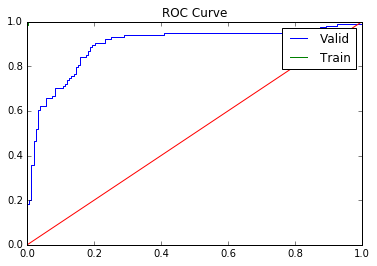

In [60]:
def model_performance(model =  ensemble):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance(ensemble)

In [61]:
# Train a stacked ensemble using the GBM  GLM and NB above
ensemble1_0 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_0",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_nb.model_id])
ensemble1_0.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.999910031489
valid accuracy: 0.895454043915


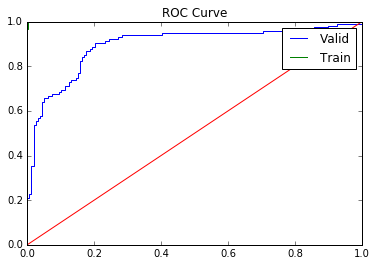

In [64]:
model_performance(ensemble1_0)

In [63]:
# Train a stacked ensemble using the GBM  GLM and DL above
ensemble1_1 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_1",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_dl.model_id])
ensemble1_1.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.990721997301
valid accuracy: 0.898267681783


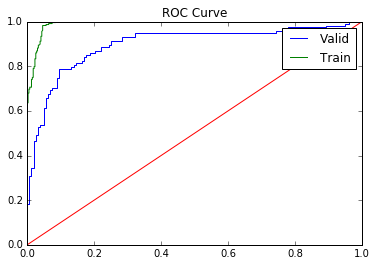

In [21]:
model_performance(ensemble1_1)

In [26]:
# Train a stacked ensemble using the GBM  GLM  DL and NB above
ensemble1_2 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_2",
                                       base_models=[my_gbm.model_id, my_rf.model_id, my_dl.model_id, my_nb.model_id])
ensemble1_2.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.990238416554
valid accuracy: 0.897219463754


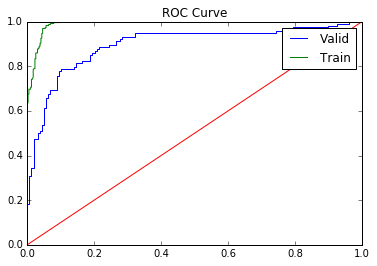

In [27]:
model_performance(ensemble1_2)

In [65]:
# Train a stacked ensemble using the GBM  DL above
ensemble1_3 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_3",
                                       base_models=[my_gbm.model_id, my_dl.model_id])
ensemble1_3.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.982079397211
valid accuracy: 0.898488359263


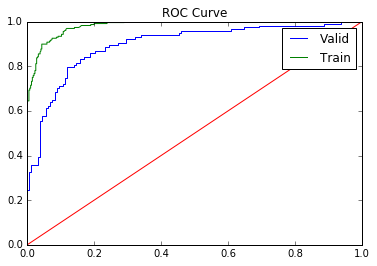

In [66]:
model_performance(ensemble1_3)

In [67]:
# Train a stacked ensemble using the RF L above
ensemble1_4 = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial1_4",
                                       base_models=[my_rf.model_id, my_dl.model_id])
ensemble1_4.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.903598740441
valid accuracy: 0.874324175218


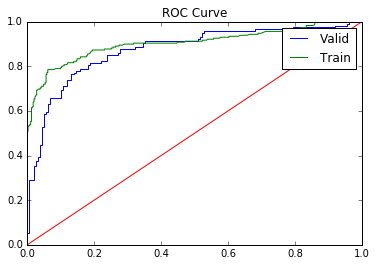

In [76]:
model_performance(my_dl)

## Predict with Model 

In [78]:
df_test = pd.read_csv('F:/Titanic/data/test.csv')

replace_age_fraction(df_test)
replace_na_to_mode(df_test)

0
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [79]:
hdf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [80]:
def get_prediction(model= ensemble1_1, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [81]:
df_submission = get_prediction(my_dl,hdf_data=hdf_test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [82]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)

In [46]:
# h2o.shutdown()